# aiapy: A SunPy affiliated package for analyzing data from the Atmospheric Imaging Assembly

In [1]:
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.time
from astropy.visualization import time_support, ImageNormalize, LogStretch
import numpy as np
import matplotlib.pyplot as plt
import sunpy
import sunpy.map
from sunpy.net import Fido, attrs as a
from sunpy.time import parse_time

import aiapy
from aiapy.psf import psf, deconvolve
from aiapy.calibrate import (register,update_pointing,correct_degradation, estimate_error,
                             degradation,normalize_exposure, respike, fetch_spikes)
from aiapy.calibrate.util import get_correction_table
from aiapy.response import Channel

import matplotlib as mpl
# Increases the figure size in this notebook.
mpl.rcParams["savefig.dpi"] = 150
mpl.rcParams["figure.dpi"] = 150

The Atmospheric Imaging Assembly (AIA) instrument onboard the NASA Solar Dynamics Observatory (SDO) spacecraft has observed the full- disk of the Sun, nearly continuously, for the last ten years. 
It is one of three instruments on SDO, along with the Helioseismic and Magnetic Imager (HMI) and the Extreme Ultraviolet Variability Experiment (EVE). 
AIA is a narrowband imaging instrument comprised of four separate telescopes that collectively observe the full-disk of the Sun at ten different wavelengths: seven extreme ultraviolet (EUV) wavelengths, two far UV wavelengths, and one visible wavelength.

`aiapy` is a SunPy-affiliated Python package for analyzing calibrated (level 1) imaging data from AIA. 
It includes capabilities for aligning images between channels, deconvolving images with the instrument point-spread function (PSF), computing channel sensitivity as a function of wavelength, and correcting images for telescope degradation, among others.
These capabilities are divided between the three subpackages of `aiapy`:

* `aiapy.calibrate`
* `aiapy.psf`
* `aiapy.response`

In this blog post, we will demonstrate the functions in each of these subpackages on a set of example level 1 AIA images.

Before we begin, we make a note of what versions of `astropy`, `sunpy`, and `aiapy` were used in the writing of this blog post.

In [2]:
print(f'astropy v{astropy.__version__}')
print(f'sunpy v{sunpy.__version__}')
print(f'aiapy v{aiapy.__version__}')

astropy v4.2.1
sunpy v3.1.0
aiapy v0.6.3


## Obtaining AIA Data

First, we will use the `Fido` client to fetch two AIA images from the VSO: one from the 171 Å channel and one from the 335 Å channel.

In [3]:
t_start = parse_time('2012-01-01T00:00:00')
search_results = Fido.search(
    a.Time(t_start, t_start+11*u.s),
    a.Instrument.aia,
    a.Wavelength(171*u.angstrom) | a.Wavelength(335*u.angstrom),
)
search_results

Start Time,End Time,Source,Instrument,Wavelength [2],Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size,Info
,,,,Angstrom,,,,,,,Mibyte,
object,object,str3,str3,float64,str4,str9,str6,str4,str4,str8,float64,str57
2012-01-01 00:00:00.000,2012-01-01 00:00:01.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]"
Start Time,End Time,Source,Instrument,Wavelength [2],Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size,Info
,,,,Angstrom,,,,,,,Mibyte,
object,object,str3,str3,float64,str4,str9,str6,str4,str4,str8,float64,str57
2012-01-01 00:00:03.000,2012-01-01 00:00:04.000,SDO,AIA,335.0 .. 335.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [2.901 exposure] [100.00 percentd]"


In [4]:
files = Fido.fetch(search_results, max_conn=1)

Files Downloaded: 100%|██████████| 2/2 [00:01<00:00,  1.37file/s]


We can then create `sunpy.map.Map` objects from the downloaded files.

In [5]:
m_171, m_335 = sunpy.map.Map(sorted(files))

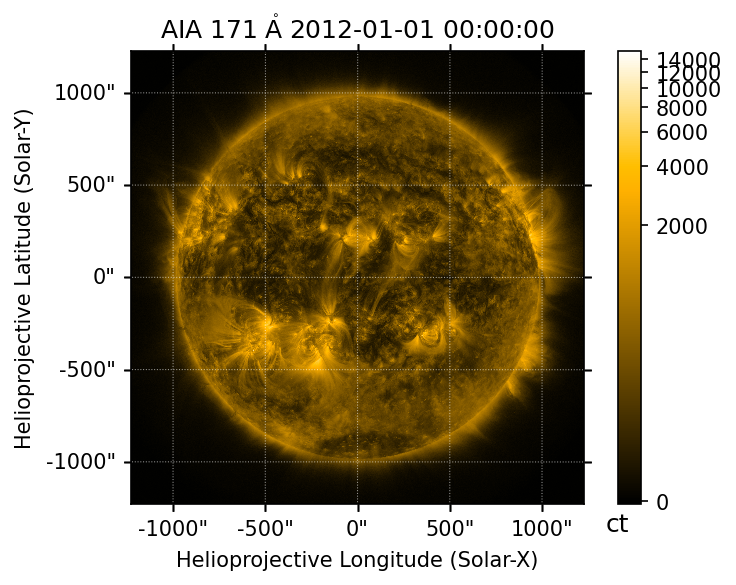

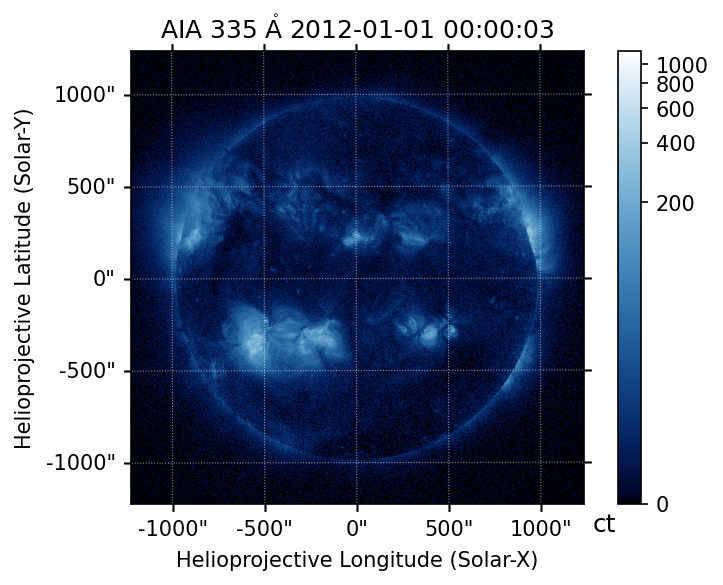

In [6]:
m_171.peek()
m_335.peek(vmin=0)

Note that both the `sunpy` and `aiapy` documentation pages include more detailed examples of how to obtain AIA data from the JSOC as well

* [sunpy: Querying and Downloading Data from JSOC](https://docs.sunpy.org/en/stable/guide/acquiring_data/jsoc.html#querying-and-downloading-data-from-jsoc)
* [sunpy: Requesting cutouts of AIA images from the JSOC](https://docs.sunpy.org/en/stable/generated/gallery/acquiring_data/downloading_cutouts.html#sphx-glr-generated-gallery-acquiring-data-downloading-cutouts-py)
* [aiapy: Requesting specific AIA images from the JSOC](https://aiapy.readthedocs.io/en/stable/generated/gallery/download_specific_data.html#sphx-glr-generated-gallery-download-specific-data-py)

## PSF Deconvolution

AIA images are subject to convolution with the instrument PSF due to effects introduced by the filter mesh of the telescope and the CCD, among others.
This has the effect of “blurring” the image.
The PSF diffraction pattern may also be particularly noticable during the impulsive phase of a flare where the intensity enhancement is very localized.
To remove these artifacts, the PSF must be deconvolved from the level 1 image.
This is because the PSF itself is defined on the pixel grid of the CCD.

We’ll calculate the PSF for the 171 Å channel using the `psf` function in the `aiapy.psf` subpackage.
The PSF model accounts for several different effects, including diffraction from the mesh grating of the filters, charge spreading, and jitter.
This implementation of the PSF calculation follows [Grigis et al (2012)](https://hesperia.gsfc.nasa.gov/ssw/sdo/aia/idl/psf/DOC/psfreport.pdf).
Further details on how the PSF is calculated can be found in that document.
Currently, this only works for $4096\times4096$ full frame images.

**Note:** The following cell will be *significantly* slower (many minutes) if you do not have a NVIDIA GPU and the [`cupy`](https://docs.cupy.dev/en/stable/) package installed.
The GPU-enabled calculation has been benchmarked at ~5 s on an NVIDIA Titan RTX.
Use of the GPU can be explicitly disabled by setting `use_gpu=False`.

In [7]:
psf_171 = psf(m_171.wavelength)

We can visualize the "core" of the PSF by cropping near the center of the array.
The diffraction “arms” extending from the center pixel can often be seen in flare observations due to the intense, small-scale brightening.

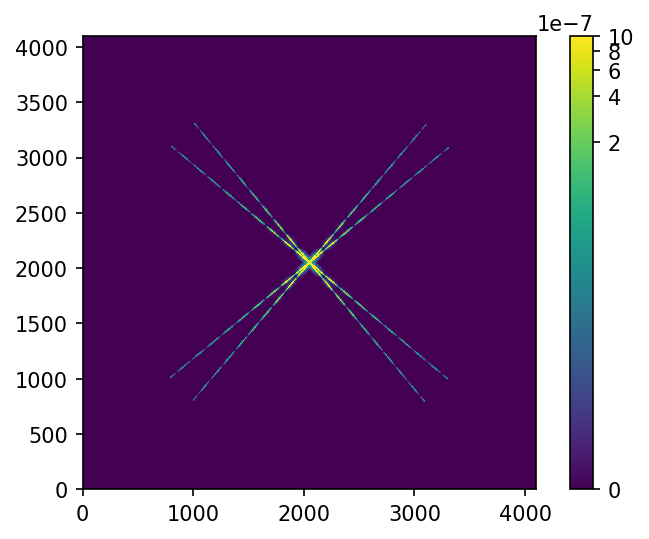

In [8]:
plt.imshow(psf_171, origin='lower', norm=ImageNormalize(vmax=1e-6, stretch=LogStretch()))
plt.colorbar()

We can then use the calculated PSF to deconvolve our 171 Å image using the `deconvolve` function in `aiapy.psf`.
This deconvolution algorithm is an implementation of the well-known [Richardson-Lucy algorithm](https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution).
If the PSF is not explicitly passed in, the PSF for that wavelength will be computed automatically.
When deconvolving many images, it is highly recommend to precompute the PSF function for each desired wavelength.

**NOTE:** The deconvolution of the image can also be optionally accelerated with a NVIDIA GPU and `cupy`.
On a Titan RTX, deconvolution of a full $4096\times4096$ image has been benchmarked at $\le1$ s.
On a CPU, the equivalent operation should take ~25 s.

In [9]:
m_171_deconvolved = deconvolve(m_171, psf=psf_171)

We can now zoom in on some loop structures that extend off the limb to examine the differences between our image before and after deconvolution.

In [10]:
blc = SkyCoord(800,150,unit='arcsec',frame=m_171.coordinate_frame)
fov = {'width': 400*u.arcsec, 'height': 400*u.arcsec}
m_171_cutout = m_171.submap(blc, **fov)
m_171_deconvolved_cutout = m_171_deconvolved.submap(blc, **fov)

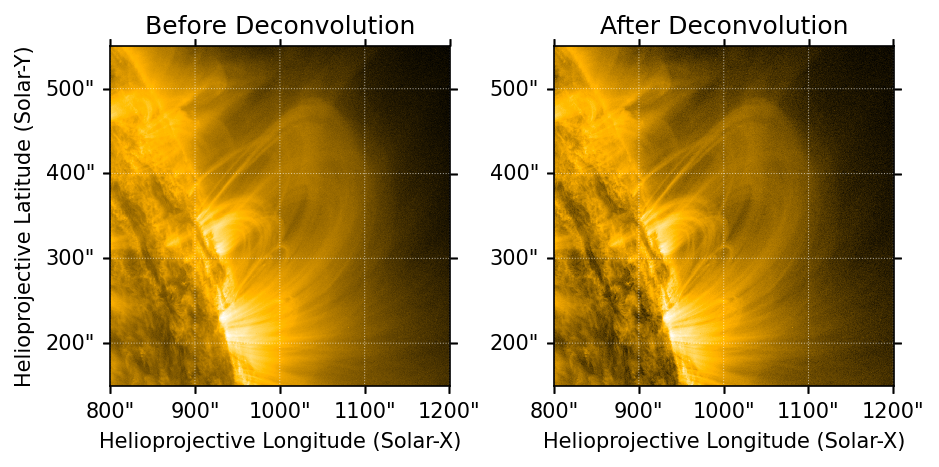

In [11]:
fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(121, projection=m_171_cutout)
m_171_cutout.plot(axes=ax, title='Before Deconvolution')
ax = fig.add_subplot(122, projection=m_171_deconvolved_cutout)
m_171_deconvolved_cutout.plot(axes=ax, title='After Deconvolution')
ax.coords[1].set_axislabel(' ')

## Respiking Level 1 Images

The `aiapy.calibrate` module contains a number of useful functions, including the ability to "respike" images through the `respike` function.
AIA level 1 images have been corrected for hot-pixels (commonly referred to as “spikes”) using an automated correction algorithm which detects them, removes them, and replaces the “holes” left in the image via interpolation. 
However, for certain research topics, this automated hot-pixel removal process may result in unwanted removal of bright points which may be physically meaningful. The `respike` function allows you to revert this removal by putting back all the removed pixel values. 
This corresponds to the `aia_respike.pro` IDL procedure as described in the [SDO Analysis Guide](https://www.lmsal.com/sdodocs/doc/dcur/SDOD0060.zip/zip/entry/index.html).

We will create a "respiked" version of our level 1 171 Å image.
This function will query the JSOC for the relevant "spikes" file which contains the locations (in pixel coordinates) and associate intensities for each of the hot pixels.
The hot pixel values are then replaced in the image at the appropriate locations.

In [12]:
m_171_respiked = respike(m_171)

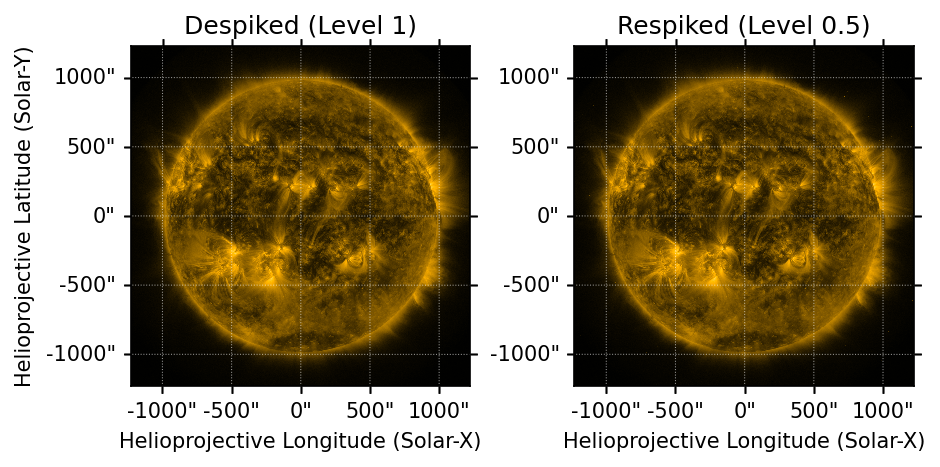

In [13]:
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(121, projection=m_171)
m_171.plot(axes=ax)
ax.set_title(f"Despiked (Level {m_171.processing_level:.0f})")
ax = fig.add_subplot(122, projection=m_171_respiked)
m_171_respiked.plot(axes=ax)
ax.set_title(f"Respiked (Level {m_171_respiked.processing_level})")
ax.coords[1].set_axislabel(' ')

Looking at the two images, it is not obvious by visual inspection what the differences are between the despiked and respiked maps.
We can use the `fetch_spikes` functions (which is called automatically by `respike`) to find the intensity values and the associated pixel coordinates

In [14]:
pix_coords, vals = fetch_spikes(m_171,)

We can then use the pixel coordinates to find the "despiked" intensity values and plot the distributions of the "despiked" and "respiked" values.

In [15]:
vals_despiked = m_171.data[pix_coords.y.value.round().astype(int), pix_coords.x.value.round().astype(int)]

Text(0, 0.5, 'Number of Pixels')

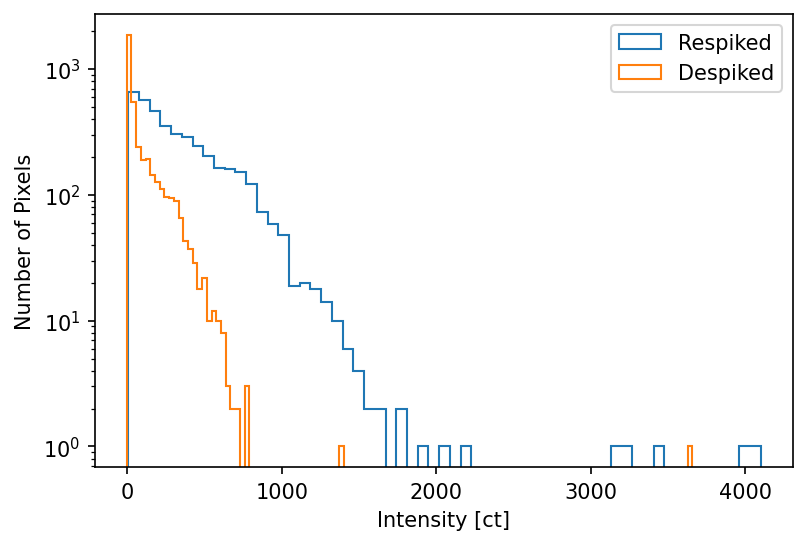

In [16]:
plt.hist(vals, bins='scott', log=True, histtype='step', label='Respiked');
plt.hist(vals_despiked, bins='scott', log=True, histtype='step', label='Despiked');
plt.legend()
plt.xlabel(f'Intensity [{m_171.unit.to_string()}]')
plt.ylabel('Number of Pixels')

Additionally, we can plot the coordinates of each of our hot pixels on our "respiked" map.
We can convert the above pixel coordinates to world coordinates using the `.pixel_to_world()` method on our level 1 map.
Note that we can also return the world coordinates from the `fetch_spikes` function automatically by passing in the `as_coords=True` keyword argument.

In [17]:
spike_coords = m_171.pixel_to_world(pix_coords.x, pix_coords.y)

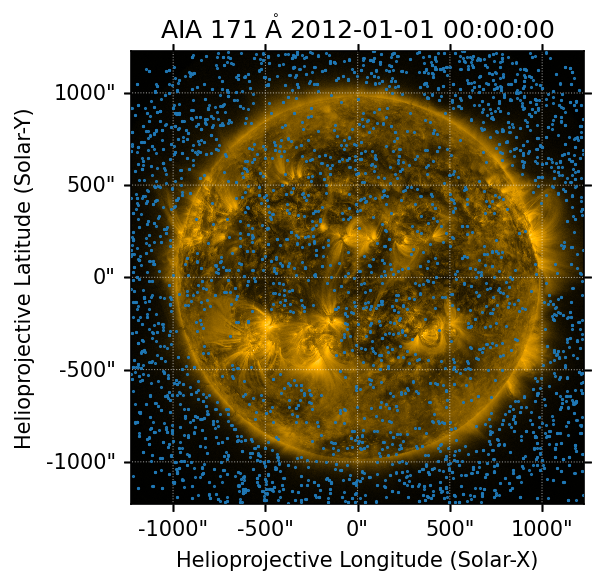

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=m_171_respiked)
m_171_respiked.plot(axes=ax)
ax.plot_coord(spike_coords, marker='.', ls=' ', markersize=1)

For a more detailed example of respiking level 1 images, see [the respiking example in the aiapy example gallery](https://aiapy.readthedocs.io/en/stable/generated/gallery/replace_hot_pixels.html).

## Transforming Level 1 Images to Level 1.5

One of the most common operations performed on level 1 AIA images is "aiaprep," commonly peformed with the `aia_prep.pro` procedure in IDL.
This prep process, which promotes level 1 images to level 1.5, is a combination of two steps:

1. update pointing and
2. image registration.

The first step is accomplished through the `update_pointing` function in `aiapy.calibrate`.
This function queries the 3-hourly master pointing table stored at the JSOC to update relevant FITS keywords.

In [19]:
m_171_up = update_pointing(m_171)

We can verify this step by examining the reference pixel before and after the pointing update.

In [20]:
m_171.reference_pixel

PixelPair(x=<Quantity 2052.530029 pix>, y=<Quantity 2046.130005 pix>)

In [21]:
m_171_up.reference_pixel

PixelPair(x=<Quantity 2053.003418 pix>, y=<Quantity 2045.915161 pix>)

The second step is accomplished through `register` function in `aiapy.calibrate`.
This function performs an affine transform on the level 1 pixel grid to remove the roll angle, scale the image to resolution of 0.6 arcseconds-per-pixel, and shift the center of the image to the center of the Sun.
The original intensity values are then reinterpolated onto this transformed grid.

In [22]:
m_171_L15 = register(m_171_up)

We can verify that the image has been transformed appropriately by comparing at the `scale` and `rotation_matrix` attributes before and after registration.
Note that the `rotation_matrix` is now diagonalized, meaning that the world and pixel grids are aligned.

In [23]:
print(m_171_up.scale)
print(m_171_up.rotation_matrix)

SpatialPair(axis1=<Quantity 0.599489 arcsec / pix>, axis2=<Quantity 0.599489 arcsec / pix>)
[[ 9.99999944e-01 -3.36028235e-04]
 [ 3.36028235e-04  9.99999944e-01]]


In [24]:
print(m_171_L15.scale)
print(m_171_L15.rotation_matrix)

SpatialPair(axis1=<Quantity 0.6 arcsec / pix>, axis2=<Quantity 0.6 arcsec / pix>)
[[ 1.00000000e+00 -2.06232805e-20]
 [-2.06232775e-20  1.00000000e+00]]


Note that we can also combine these two operations into a "prep" function to imitate `aiaprep.pro`.

In [25]:
def prep(smap):
    return register(update_pointing(smap))

In [26]:
m_335_L15 = prep(m_335)

Applying this "prep" procedure means that our 171 Å and 335 Å images are now interpolated to the same pixel grid.

In [27]:
print(m_335_L15.scale)
print(m_335_L15.rotation_matrix)

SpatialPair(axis1=<Quantity 0.6 arcsec / pix>, axis2=<Quantity 0.6 arcsec / pix>)
[[ 1.00000000e+00 -4.95971886e-20]
 [-4.83278058e-19  1.00000000e+00]]


Before performing any operations between two maps from different channels, one should always register each image such that the pixel grids of each image are aligned.
For more information on transforming level 1 images to level 1.5, see the following examples in the `aiapy` example gallery:

* [Registering and aligning level 1 data](https://aiapy.readthedocs.io/en/stable/generated/gallery/prepping_level_1_data.html)
* [Updating pointing and observer keywords in the FITS header](https://aiapy.readthedocs.io/en/stable/generated/gallery/update_header_keywords.html)

## Degradation Correction

The performance of the AIA telescope is unfortunately degrading over time, leading to the resulting images becoming increasingly dim.
We can correct for this by modeling the degradation over time using the `degradation` function.
This function calculates the degradation factor $d(t)$ as,

$$
d(t) = \frac{A_{eff}(t_{e})}{A_{eff}(t_0)}(1 + p_1\delta t + p_2\delta t^2 + p_3\delta t^3),
$$

where the leading coefficient is the ratio between the effective area at some epoch time $t_e$ and the initial time $t_0$.
The term in the parentheses represents an interpolation from $t_e$ to the selected time $t$, where $\delta t=t-t_e$.
$p_1,p_2,p_3$ as well as $A_{eff}(t_e)$ and $A_{eff}(t_0)$ are retrieved from the JSOC (by default) or a user-supplied table.

We can use this function to calculate the degradation of the 335 Å channel from the start of the SDO mission to now.

In [28]:
t_begin = parse_time('2010-03-25T00:00:00')
now = astropy.time.Time.now()
time_window = t_begin + np.arange(0, (now - t_begin).to(u.day).value, 7) * u.day

First, we'll query the degradation calibration table from the JSOC.
Doing this ahead of time avoids repeated network calls when we want to repeatedly calculate the degradation.

In [29]:
correction_table = get_correction_table()

/home/wbarnes/anaconda3/envs/aiapy-dev/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/wbarnes/anaconda3/envs/aiapy-dev/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/wbarnes/anaconda3/envs/aiapy-dev/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


We can then calculate the 335 Å degradation using the above correction table.

In [30]:
d_335 = degradation(m_335.wavelength, time_window, correction_table=correction_table)

Note that we can also use the `.date` attribute on our 335 Å map to compute the degradation at the time of that map

In [31]:
d_335_map = degradation(m_335.wavelength, m_335.date, correction_table=correction_table)

The degradation calibration is routinely updated (e.g. using data from sounding rocket flights), with new versions added to the table returned from the JSOC.
We can look at older versions of the calibration to see how the predicted degradation has changed using the `calibration_version` keyword argument.
Note that the default version in `aiapy v0.6.3` is 10.

In [32]:
d_335_v9 = degradation(m_335.wavelength, time_window, calibration_version=9, correction_table=correction_table)
d_335_v8 = degradation(m_335.wavelength, time_window, calibration_version=8, correction_table=correction_table)

And compare the two degradation curves as a function of time over the lifetime of the mission.

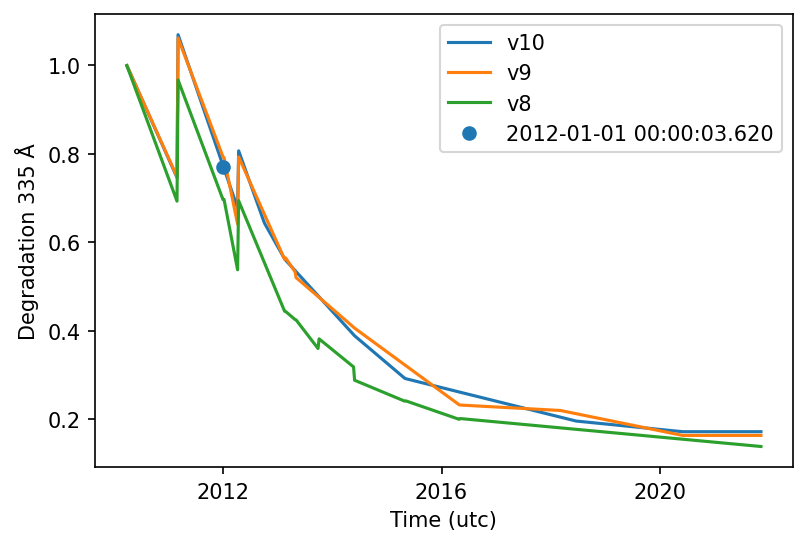

In [33]:
with time_support(format='jyear'):
    plt.plot(time_window, d_335, label='v10')
    plt.plot(time_window, d_335_v9, label='v9')
    plt.plot(time_window, d_335_v8, label='v8')
    plt.plot(m_335.date, d_335_map, linestyle='', marker='o', color='C0', label=m_335.date.iso)
plt.ylabel('Degradation 335 Å')
plt.legend()

Additionally, `aiapy.calibrate` also includes the `correct_degradation` function which accepts a `sunpy.map.Map`, calculates the degradation factor, divides the image data by this degradation factor, and returns a new corrected map.

In [34]:
m_335_corrected = correct_degradation(m_335, correction_table=correction_table)

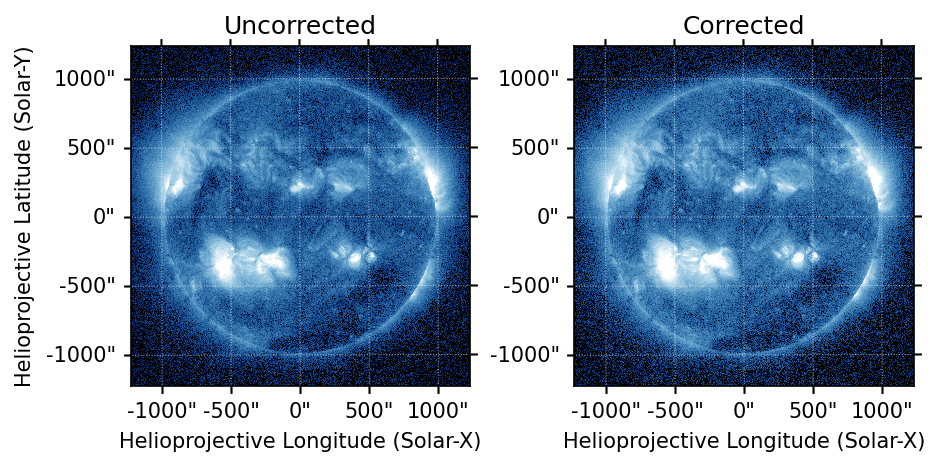

In [35]:
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(121, projection=m_335)
m_335.plot(axes=ax, vmin=0, vmax=150,title='Uncorrected')
ax = fig.add_subplot(122, projection=m_335_corrected)
m_335_corrected.plot(axes=ax, vmin=0, vmax=150, title='Corrected')
ax.coords[1].set_axislabel(' ')

## Computing Uncertainties

One of the newest additions to `aiapy` is the function for computing uncertainties on AIA intensities.
This is done through the `estimate_error` function in `aiapy.calibrate`.
`estimate_error` is an exact port of the SSWIDL function `aia_bp_estimate_error.pro`.
This calculation includes errors from the shot noise, read noise, quantization, and onboard compression.
The calculation can also optionally include contributions from the photometric calibration and errors in the atomic data.

We can pass in the (unitful) data array attached to our 171 Å map and compute the intensities.

In [36]:
errors_171 = estimate_error(m_171_L15.quantity/u.pix, m_171_L15.wavelength)

/home/wbarnes/anaconda3/envs/aiapy-dev/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 10 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/wbarnes/anaconda3/envs/aiapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


To easily visualize the spatial distribution of these uncertainties, we can create a new `sunpy.map.Map` object from these errors.

In [37]:
m_171_errors = sunpy.map.Map(errors_171.value, m_171_L15.meta)

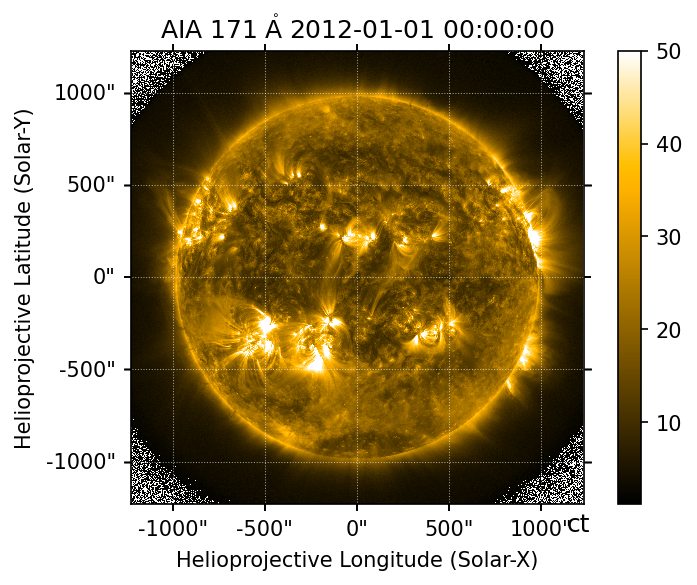

In [38]:
m_171_errors.peek(norm=ImageNormalize(vmax=50))

We can also use the `include_chianti` flag to understand how the presence of atomic data errors from CHIANTI affect the uncertainty.

In [39]:
errors_171_chianti = estimate_error(m_171_L15.quantity/u.pix, m_171_L15.wavelength, include_chianti=True)

/home/wbarnes/anaconda3/envs/aiapy-dev/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 10 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/wbarnes/anaconda3/envs/aiapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Similarly, we can look at how the photometric calibration, using the calibration from EVE, affects the uncertainties.

In [40]:
errors_171_eve = estimate_error(m_171_L15.quantity/u.pix, m_171_L15.wavelength, include_eve=True)

We can then look at the distribution of these uncertainties with these different combinations of keyword arguments to understand how these different options affect the resulting distribution of errors.
Note that the inclusion of the atomic data results in the largest errors because there is an additional 25% (for 171 Å) uncertainty assumed on the input intensities.

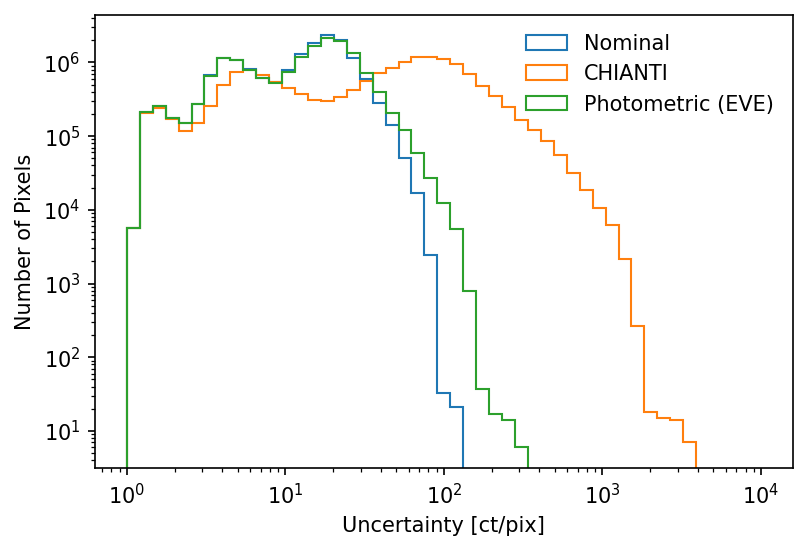

In [41]:
hist_params = {'bins': np.logspace(0,4,50), 'histtype': 'step', 'log': True}
plt.hist(errors_171.value.flatten(), **hist_params, label='Nominal');
plt.hist(errors_171_chianti.value.flatten(), **hist_params, label='CHIANTI');
plt.hist(errors_171_eve.value.flatten(), **hist_params, label='Photometric (EVE)');
plt.xlabel('Uncertainty [ct/pix]')
plt.ylabel('Number of Pixels')
plt.xscale('log')
plt.legend(frameon=False)

## Exposure Time Normalization

The `aiapy.calibrate` subpackage also includes a function for normalizing images by the exposure time.

In [42]:
m_171_norm = normalize_exposure(m_171_L15)

The units of the resulting image reflect this operation.

In [43]:
print(m_171_L15.unit)
print(m_171_norm.unit)

ct
ct / s


Note that this function resets the exposure time of the normalized image to 1

In [44]:
print(m_171_L15.exposure_time)
print(m_171_norm.exposure_time)

1.999598 s
1.0 s


As of `sunpy` v3.1, it is also possible to simply divide maps by scalar quantities

In [45]:
m_171_norm = m_171_L15 / m_171_L15.exposure_time

This option still properly accounts for the change in units but does **not** reset the exposure time.

In [46]:
m_171_norm.unit

Unit("ct / s")

In [47]:
m_171_norm.exposure_time

<Quantity 1.999598 s>

## Wavelength Response Functions

Lastly, the `aiapy.response` subpackage includes the `Channel` object for computing the wavelength response function of each channel as well as providing various pieces of metadata for each channel.

In [48]:
c = Channel(m_335.wavelength)

In [49]:
print(c.channel)
print(c.telescope_number)

335.0 Angstrom
1


The wavelength response is a combination of the (wavelength-dependent) effective area and the gain of the telescope such that $R(\lambda,t) = A_{eff}(\lambda)G(\lambda)$.
According to Section 2 of [Boerner et al. (2012)](http://adsabs.harvard.edu/abs/2012SoPh..275...41B), the effective area is given by,

$$
A_{eff}(\lambda) = A_{geo}R_P(\lambda)R_S(\lambda)T_E(\lambda)T_F(\lambda)D(\lambda)Q(\lambda),
$$

where $A_{geo}$ is the geometrical collecting area, $R_{P,S}$ are the reflectances of the primary and secondary mirrors, respectively,
$T_{E,F}$ are the transmission efficiency of the entrance and focal-plane filters, respectively, $D$ is the contaminant transmittance of the optics and $Q$ is the quantum efficiency of the CCD.

We can compute the wavelength response for the 335 Å channel using the following method.

In [50]:
r = c.wavelength_response()

Each of the individual components of the effective area are also available as properties on the `Channel` object.

In [51]:
print(c.geometrical_collecting_area)
print(c.primary_reflectance)
print(c.focal_plane_filter_efficiency)
print(c.contamination)
print(c.quantum_efficiency)
print(c.gain)

83.0 cm2
[0.         0.         0.         ... 0.18931125 0.18933147 0.18935168]
[5.95474e-01 5.93567e-01 5.91666e-01 ... 3.08021e-05 3.06914e-05
 3.05812e-05]
[0.96578515 0.96544755 0.9651096  ... 0.4387496  0.4387496  0.4387496 ]
[0.8513821  0.8509894  0.8506473  ... 0.09263941 0.09265867 0.09267791]
[7.7200723  7.6893153  7.658802   ... 0.21449412 0.21447031 0.21444647] ct / ph


The `.wavelength_response` method also includes several keyword arguments for including the effects of degradation and EVE cross-calibration in the computation of the wavelength response function.

In [52]:
r_time = c.wavelength_response(obstime=m_335.date)
r_time_eve = c.wavelength_response(obstime=m_335.date, include_eve_correction=True)

/home/wbarnes/anaconda3/envs/aiapy-dev/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/wbarnes/anaconda3/envs/aiapy-dev/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/wbarnes/anaconda3/envs/aiapy-dev/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


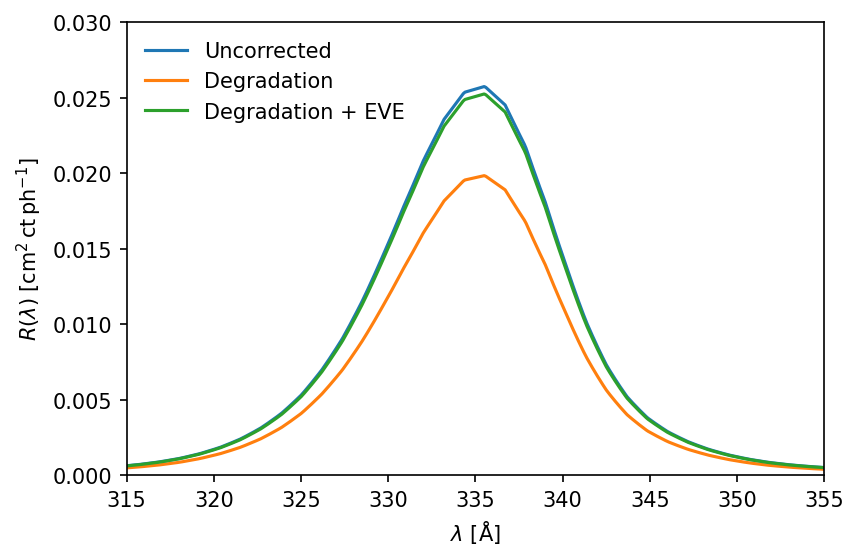

In [53]:
plt.plot(c.wavelength,r,label='Uncorrected')
plt.plot(c.wavelength,r_time,label='Degradation')
plt.plot(c.wavelength,r_time_eve,label='Degradation + EVE')
plt.xlim([315,355])
plt.ylim([0,0.03])
plt.xlabel('$\lambda$ [Å]')
plt.ylabel(f'$R(\lambda)$ [{r.unit.to_string(format="latex_inline")}]')
plt.legend(loc=2, frameon=False)

Note that these wavelength responses, when combined with atomic data (e.g. from CHIANTI), can be used to compute the temperature response functions of each AIA channel using Section 2.5 of Boerner et al. (2012).
More information about this subpackage can be found in the [Computing wavelength response functions](https://aiapy.readthedocs.io/en/stable/generated/gallery/calculate_response_function.html#sphx-glr-generated-gallery-calculate-response-function-py) example in the `aiapy` example gallery.

## Resources

In addition to this blog post, there are also a number of resources for learning more about `aiapy`:

- [Source code on GitLab](https://gitlab.com/LMSAL_HUB/aia_hub/aiapy)
- [Documentation](https://aiapy.readthedocs.io/en/stable/)
- [Example Gallery](https://aiapy.readthedocs.io/en/stable/generated/gallery/index.html)
- [Paper in the Journal of Open Source Software (JOSS)](https://joss.theoj.org/papers/10.21105/joss.02801)

`aiapy` is under active development and, just as with the core `sunpy` package and all other affilitated packages, contributions from the community are alwyas welcome.
To report a bug, request a feature, or simply ask a question, feel free to open an issue on [GitLab](https://gitlab.com/LMSAL_HUB/aia_hub/aiapy/-/issues).